# VaDeSC $Clustering$ Explanation  

## Hemodialysis Dataset Application Case Study

In [16]:
# Libraries import
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import math
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import shap

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder 
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


# Custom support library
from explainer_utils import *


### Data import and preprocessing

We run the explanation algorithm on the observations that VaDeSC used in the learning phase (i.e. training data). We do that to extract meaningful explanations of what the model learnt and what information it based the subgroup discovery on.

In [2]:
# Load data files
X_filename = "Data/X.npy"
c_filename = "Data/c.npy" 
pcz_filename = "Data/pcz.npy" 
t_filename = "Data/t.npy" 
t_or_filename = "Data/t_original.npy"
X_or_filename = "Data/X_original.npy"

X = np.load(X_filename)
X_orig = np.load(X_or_filename)
c = np.load(c_filename)
pcz = np.load(pcz_filename)
t = np.load(t_filename)
t_orig = np.load(t_or_filename)


# Select training data and filter out features following clinical experts' indications 
X, cov_names = HemoData_preparation(X)

X_orig, _ = HemoData_preparation(X_orig)


# extract training set only
n_train_obs = int(len(X)*0.7)


X = pd.DataFrame(X[:n_train_obs])
X_orig = pd.DataFrame(X_orig[:n_train_obs])
c = pd.DataFrame(c[:n_train_obs], columns=['c'])
pcz = pd.DataFrame(pcz[:n_train_obs])
t = pd.DataFrame(t[:n_train_obs], columns=['t'])
t_orig = pd.DataFrame(t_orig[:n_train_obs], columns=['t'])

To mimic VaDeSC clustering model we include the time-to-event information as an additional input to the classifier

In [3]:
Xt = pd.concat([X, t], axis = 1)
Xt_orig = pd.concat([X_orig, t_orig], axis = 1)
feature_names = np.append(np.array(cov_names),'t')

### Experiment configuration

In order to profile clusters we will compute feature importance scores (Shapley values) on a group of _Prototypes_ that represent at best each cluster. In order to do that, we will sample a number (i.e. `sample_size`) of observations with $p(c|z,t)>threshold$.

In [4]:
clusters_labs = [0,1]
num_clusters = len(clusters_labs)

# Number of prototypes to sample from each class
sample_size = 500
threshold = 0.75

np.random.seed(42)

In [5]:
# Build a prototypes dataset for global interpretation

proto_id_all = extract_prototypes_list(Xt, clusters_labs, pcz, n_prototypes = sample_size, p_threshold = threshold)  

# Build a dataframe with cluster prototypes data and an array of cluster labels associated with the sampled prototypes
Prototypes_display, cluster_labels = build_prototypes_ds(Xt, num_clusters = num_clusters, proto_id_list = proto_id_all)

# Build a dataframe with the same prototypes but features unscaled (for final plotting of results)
Proto_original, _ = build_prototypes_ds(Xt_orig, num_clusters = num_clusters, proto_id_list = proto_id_all)


Prototypes_display.reset_index(drop=True, inplace=True)
Proto_original.reset_index(drop=True, inplace=True)

In [6]:
# check prototypes numerosity
unique, counts = np.unique(cluster_labels, return_counts=True)
dict(zip(unique, counts))

{0.0: 500, 1.0: 212}

### XGBoost Classifier training

We now train an XGBoost classifier to predict cluster labels defined by VaDeSC. We chose XGBoost as this tree-based classifier allows for exact computation of Shapley Values in polynomial time through the TreeExplainer algorithm ([Lundberg _et al._ , 2020](https://www.nature.com/articles/s42256-019-0138-9)). 

In [7]:
X_train, X_test, y_train, y_test = train_test_split(Xt, c, test_size=0.1, random_state=42)
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

In [8]:
params = {
    "eta": 0.001,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "eval_metric": "error"
}

model = xgb.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=5, early_stopping_rounds=200)

[0]	test-error:0.32381
[5]	test-error:0.21905
[10]	test-error:0.20952
[15]	test-error:0.20000
[20]	test-error:0.19048
[25]	test-error:0.19048
[30]	test-error:0.20952
[35]	test-error:0.20952
[40]	test-error:0.20952
[45]	test-error:0.22857
[50]	test-error:0.21905
[55]	test-error:0.21905
[60]	test-error:0.21905
[65]	test-error:0.22857
[70]	test-error:0.22857
[75]	test-error:0.21905
[80]	test-error:0.20952
[85]	test-error:0.20000
[90]	test-error:0.20952
[95]	test-error:0.20000
[100]	test-error:0.20000
[105]	test-error:0.21905
[110]	test-error:0.20952
[115]	test-error:0.21905
[120]	test-error:0.21905
[125]	test-error:0.21905
[130]	test-error:0.21905
[135]	test-error:0.21905
[140]	test-error:0.21905
[145]	test-error:0.21905
[150]	test-error:0.20952
[155]	test-error:0.21905
[160]	test-error:0.20952
[165]	test-error:0.20952
[170]	test-error:0.20952
[175]	test-error:0.20952
[180]	test-error:0.20952
[185]	test-error:0.20952
[190]	test-error:0.20952
[195]	test-error:0.20952
[200]	test-error:0.209

### SHAP Values computation

In [9]:
# Fit TreeExplainer on the whole original dataset (+ time information)
explainer = shap.TreeExplainer(model, Xt, model_output="probability")

# Compute and aggregate shapley values on cluster prototypes
shap_values = explainer.shap_values(Prototypes_display)

 96%|=================== | 687/712 [00:13<00:00]       

### Plotting Results

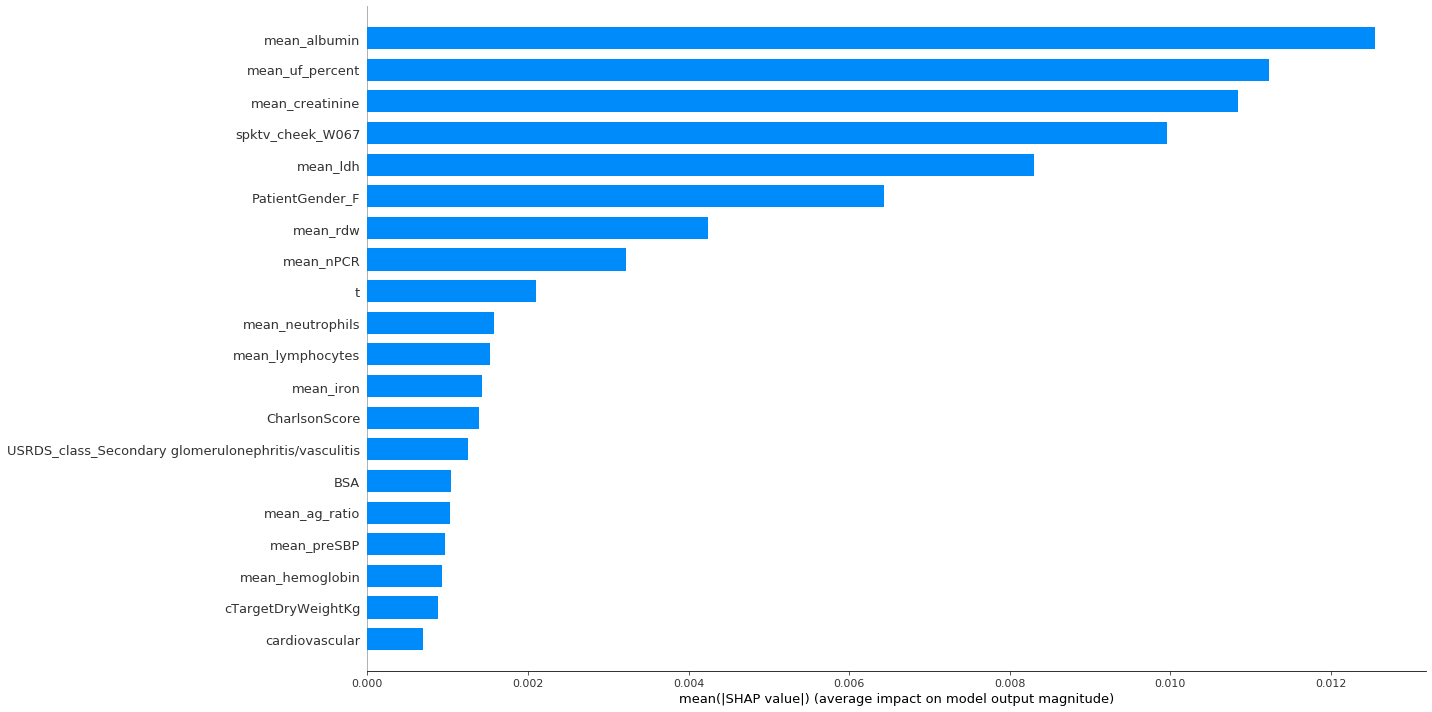

In [10]:
# Legacy SHAP library summary plot
shap.summary_plot(shap_values,Prototypes_display, feature_names=feature_names, plot_type='bar', show=False, plot_size=(20,10))
plt.tight_layout()

#plt.savefig("Plots/H16_bar_summary.png", dpi=300)

#### SHAP Interaction values

SHAP algorithm applied to tree-based models allows for the computation of SHAP values for interaction terms as well. 

In [11]:
# Explainer fitting ()
explainer_raw = shap.TreeExplainer(model,Xt, model_output="raw", feature_perturbation="tree_path_dependent")

# obtain interaction values
shap_interaction_values = explainer_raw.shap_interaction_values(Prototypes_display)

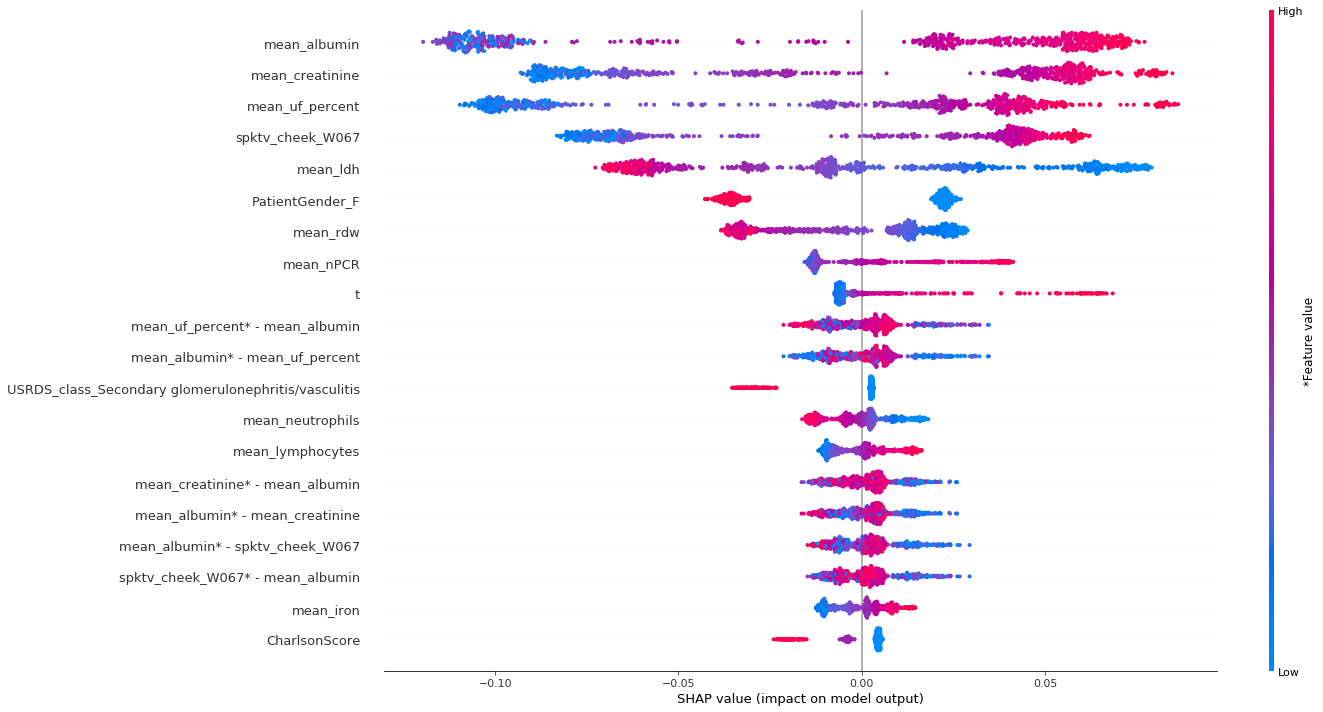

In [12]:
shap.summary_plot(shap_interaction_values, Prototypes_display, feature_names=feature_names, plot_type="compact_dot", show=False, plot_size=(20,10))
plt.tight_layout()
#plt.savefig("/Plots/Hemo_clust_interactions.png", dpi=300)

#### Plotting of Features Attributions and Original Distributions

To obtain a _global_ interpretation of the classification of observations in the clusters identified by VaDeSC, we aggregate the SHAP values computed on the _cluster prototypes_ by taking the mean absolute value of the _local_ values (i.e. the SHAP values associated to each observation).

Once we do that, we take the top_n most relevant features for plotting.

In [13]:
global_shaps = np.abs(pd.DataFrame(shap_values)).mean(axis=0)

In [14]:
top_n = 10
top_feature_names, shap_bar_values, Plot_df = prepare_summary_plot_data(global_shaps, 
                                                                        top_n, 
                                                                        Proto_original, 
                                                                        cluster_labels, 
                                                                        feature_names)

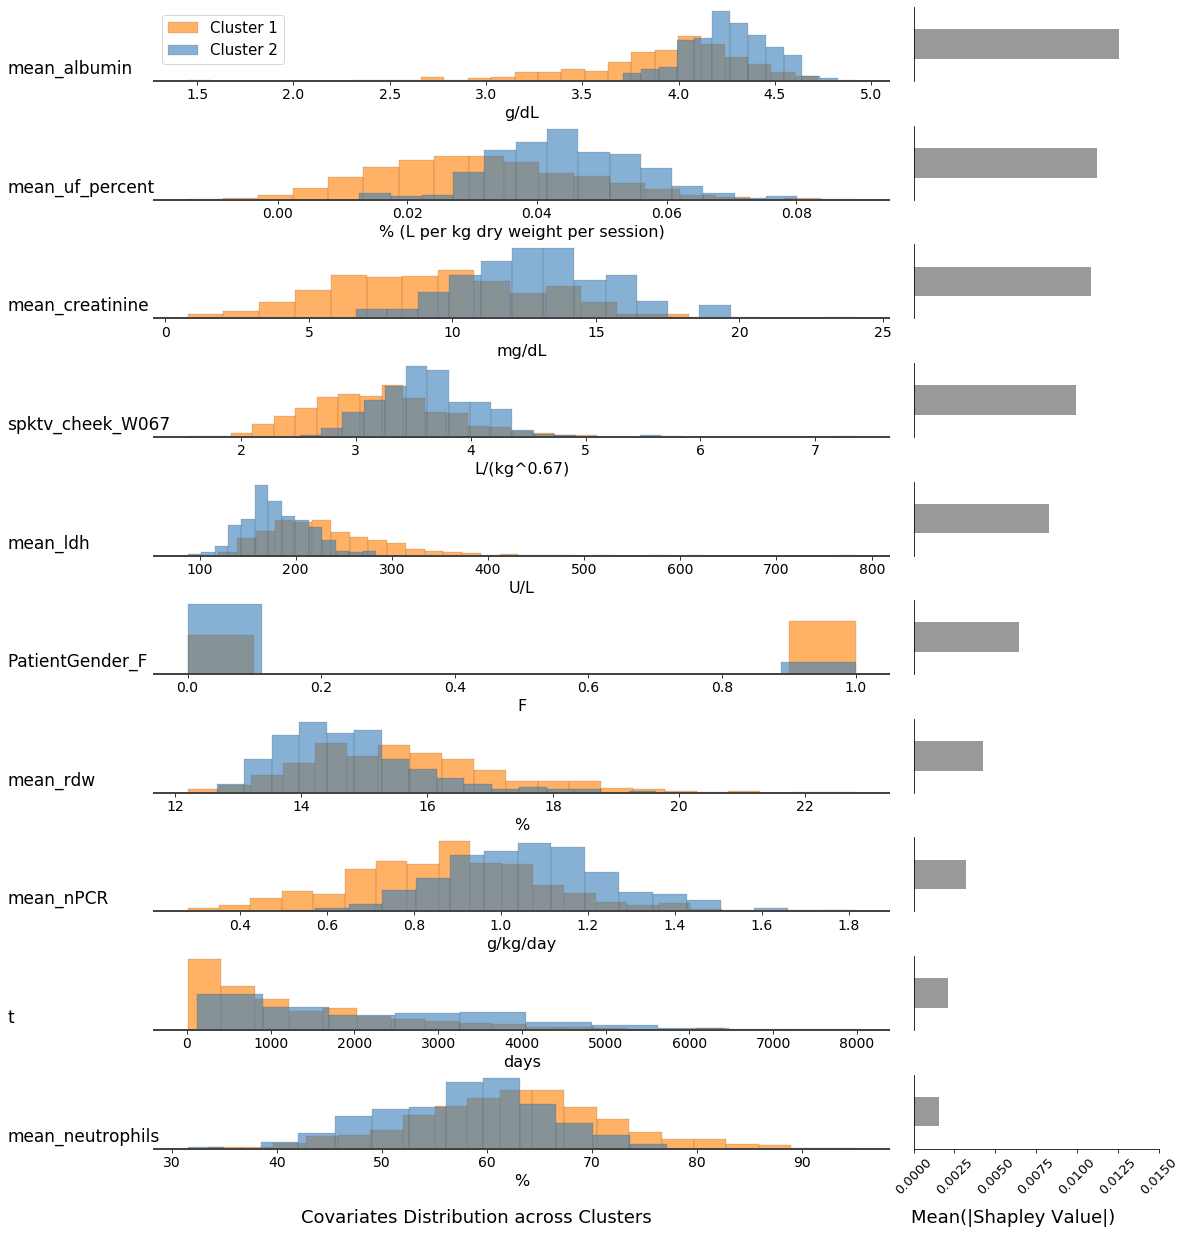

In [19]:
# custom plot as shown in the paper
unit_measures = ['g/dL', '% (L per kg dry weight per session)', 'mg/dL', 'L/(kg^0.67)', 'U/L', 'F', '%', 'g/kg/day', 'days', '%']

fig = plot_topN_features(Plot_df, top_n, top_feature_names, shap_bar_values, unit_measures)


#plt.savefig("Plots/HemoClustering_wDistr_top10_unscaled.png", dpi=300)

In [ ]:
# Save tabular results
importance_df = pd.concat([pd.DataFrame(feature_names), pd.DataFrame(global_shaps)], axis=1)
importance_df.columns = ['feature', 'importance']
#importance_df.to_csv("Clustering_Feat_Attribution.txt")